<a href="https://colab.research.google.com/github/mhask94/cs474_labs_f2019/blob/conv2linear/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# imports for training data
!if ( ! ls . | grep pytransform ); then git clone https://github.com/mhask94/pytransform.git; fi
# !git clone https://github.com/mhask94/pytransform.git
from pytransform.common import skew
from pytransform.quaternion import Quaternion as Quat
import numpy as np

pytransform


In [0]:
# imports for pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace

In [0]:
# classes for quadrotor state and dynamics
class State():
    def __init__(self, arr=np.empty(0)):
        if len(arr) == 0:
            self.arr = np.zeros((10,1), dtype=np.float64)
            self.arr[3] = 1
        else:
            assert arr.shape == (10, 1)
            if not arr.dtype == np.float64:
              arr = np.array(arr, dtype=np.float64)
            arr.dtype = np.float64
            self.arr = arr

    def __getitem__(self, position):
        return self.arr[position]
    def __str__(self):
        s = 'p: ' + str(self.p.flatten()) + '\nq: ' + self.q.__str__() + \
                '\nv: ' + str(self.v.flatten())
        s = s.replace('[ ', '[')
        s = s.replace(', ', ' ')
        s = s.replace(' ]', ']')
        return s
    def __repr__(self):
        return self.__str__()
    def __add__(self, other):
        assert other.shape == (9, 1)
        out = np.empty(self.arr.shape)
        out[:3]  = self.p + other[:3]
        out[3:7] = (self.q + other[3:6]).elements
        out[7:]  = self.v + other[6:]
        return State(out)
    def __iadd__(self, other):
        assert other.shape == (9, 1)
        self.arr[:3] += other[:3]
        self.arr[3:7] = (self.q + other[3:6]).elements
        self.arr[7:] += other[6:]
        return self
    @property
    def p(self):
        return self.arr[:3]
    @property
    def q(self):
        return Quat(self.arr[3:7])
    @property
    def v(self):
        return self.arr[7:]
    @property
    def elements(self):
        return self.arr.copy()
    def copy(self):
        return State(self.arr.copy())

class Dynamics():
    def __init__(self):
        self.k1 = np.zeros((9,1))
        self.k2 = np.zeros((9,1))
        self.k3 = np.zeros((9,1))
        self.k4 = np.zeros((9,1))
        self.cd = 0.1
        e_z = np.array([[0,0,1]]).T
        self.g = 9.8065 * e_z
        self.se = 0.5

    def run(self, xu, dt):
        x,u = State(xu[:10]), xu[10:]
        self.k1 = self.f(x, u)
        self.k2 = self.f(x + self.k1*(dt/2), u)
        self.k3 = self.f(x + self.k2*(dt/2), u)
        self.k4 = self.f(x + self.k3*dt, u)
        # x += (self.k1 + 2*(self.k2 + self.k3) + self.k4) * (dt/6)
        return x + (self.k1 + 2*(self.k2 + self.k3) + self.k4) * (dt/6)

    def f(self, x, u):
        s, w = u[0], u[1:]
        dx = np.empty(self.k1.shape)
        dx[:3] = x.q.rota(x.v)
        dx[3:6] = w
        dx[6:] = -self.g*(s/self.se) - self.cd*x.v + x.q.rotp(self.g) - \
                skew(w) @ x.v
        return dx

    @property
    def state(self):
        return self.x.copy()

In [0]:
class DataGenerator():
  def __init__(self, num_states, num_inputs, dt=0.01, batch_size=50):
    self.n = num_states
    self.m = num_inputs
    self.dt = dt
    self.batch_size = batch_size
    self.pos_lim = 50
    self.att_lim = np.pi/3.5
    self.vel_lim = 10
    self.rate_lim = np.pi
    self.s_lim = 1
    self.dyn = Dynamics()

  def getRandomInput(self):
    xu = np.empty(self.n + self.m)
    xu[:2] = np.random.uniform(-self.pos_lim, self.pos_lim, 2)
    xu[2] = np.random.uniform(-self.pos_lim, 0)
    mask = np.random.uniform(size=3) > 0.2
    euler = np.random.uniform(-self.att_lim, self.att_lim, 3) * mask
    xu[3:7] = Quat.from_euler(*euler).elements.flatten()
    xu[7:10] = np.random.uniform(-self.vel_lim, self.vel_lim, 3)
    xu[10] = np.random.uniform(0, self.s_lim)
    xu[11:] = np.random.uniform(-self.rate_lim, self.rate_lim, 3)
    return xu

  def getBatch(self):
    batch_in = np.empty((self.batch_size, self.n+self.m))
    batch_out = np.empty((self.batch_size, self.n))
    for i in range(self.batch_size):
      batch_in[i] = self.getRandomInput()
      batch_out[i] = self.dyn.run(batch_in[i].reshape(-1,1), self.dt).elements.flatten()
    return batch_in, batch_out

In [6]:
def testGen():
  data_gen = DataGenerator(10,4,dt=0.01,batch_size=2)
  ran = data_gen.getRandomInput()
  print('rand: ', ran)

  x, truth = data_gen.getBatch()
  print('x: \n', x)
  print('truth: \n', truth)

  dyn = Dynamics()
  for i, state in enumerate(x):
    state = state.reshape(-1,1)
    out = dyn.run(state, 0.01).elements.flatten()
    error = out - truth[i]
    norm = np.sqrt(error @ error)
    print('norm: ', norm)

testGen()

rand:  [ 22.65623071 -35.85586152 -47.59118468   0.95669956  -0.16721869
   0.23286565  -0.05037311   5.71689689   2.83455618  -8.99871764
   0.73392403  -2.0871038    0.7375327    2.83241342]
x: 
 [[ 4.95461307e+01 -1.04381575e+01 -4.08774910e+00  9.92667362e-01
   0.00000000e+00 -0.00000000e+00  1.20878076e-01 -4.25005858e+00
  -5.40683417e+00 -5.27396585e+00  3.40692169e-01  2.50896058e-01
  -2.48720275e+00  2.53417490e+00]
 [-4.48435963e+01 -3.58206118e+01 -9.04043260e+00  9.90930234e-01
   2.65701120e-02  3.53069555e-03  1.31677012e-01  5.82027552e+00
   7.31445909e+00  6.06692916e+00  4.58223888e-01  1.70578023e+00
   1.54370443e+00  2.38300886e+00]]
truth: 
 [[ 4.95178644e+01 -1.05008129e+01 -4.14030620e+00  9.90978587e-01
   2.74837795e-03 -1.21925420e-02  1.33436230e-01 -4.50939209e+00
  -5.30339047e+00 -5.11514685e+00]
 [-4.48056670e+01 -3.57380617e+01 -8.97592129e+00  9.88971618e-01
   3.40433888e-02  1.19848180e-02  1.43640353e-01  5.89418392e+00
   7.27688934e+00  6.034849

In [7]:
def testLinearSize():
  inputs = 14
  outputs = 10
  batch = 1
  x_test = torch.zeros(batch,inputs)
  up = nn.Linear(inputs, 50)
  up_test = up(x_test)
  print('up: ', up_test.size())

  down = nn.Linear(50, outputs)
  down_test = down(up_test)
  print('down: ', down_test.size())

testLinearSize()

up:  torch.Size([1, 50])
down:  torch.Size([1, 10])


In [0]:
class ResBlock(nn.Module):
  def __init__(self, dim_in, dim_out, skip=False):
    super(ResBlock, self).__init__()
    self.skip = skip
    self.activation = nn.ReLU()
    self.layer1 = nn.Linear(dim_in, dim_in)
    self.layer2 = nn.Linear(dim_in, dim_in)
    self.layer3 = nn.Linear(dim_in, dim_out)

  def forward(self, x):
    out1 = self.activation(self.layer1(x))
    out2 = self.layer2(out1)
    skip = self.activation(out2 + out1)
    out3 = self.layer3(skip)
    if self.skip:
      return skip, out3
    else:
      return out3

class DynamicsNN(nn.Module):
  def __init__(self, num_states, num_inputs):
    super(DynamicsNN, self).__init__()
    self.up1 = nn.Linear(num_states+num_inputs, 50)
    self.up2 = ResBlock(50,  100, skip=True)
    self.up3 = ResBlock(100, 200, skip=True)
    self.dn1 = ResBlock(200, 100)
    self.dn2 = ResBlock(100, 50)
    self.dn3 = ResBlock(50,  num_states)

  def forward(self, x):
    up1 = self.up1(x)
    skip1, up2 = self.up2(up1)
    skip2, up3 = self.up3(up2)
    down1 = self.dn1(up3)
    down2 = self.dn2(skip2 + down1)
    down3 = self.dn3(skip1 + down2)
    p = down3[:,:3]
    q = down3[:,3:7]
    q1 = torch.zeros_like(q)
    q1 = q / torch.norm(q, dim=1, keepdim=True)
    # was getting nans here, but removing ReLU on output layer fixed it
    # norm = torch.norm(q, dim=1)
    # mask = norm != 0.0
    # q1[mask] = q[mask] / norm[mask].unsqueeze(-1)
    v = down3[:,7:]
    out = torch.cat((p,q1,v), dim=1)
    return out

In [13]:
def testNet():
  n = 10
  m = 4
  x_test = torch.randn(2,n+m)
  print('x_test: ', x_test)
  net = DynamicsNN(n,m)
  test = net(x_test)
  print('shape: ', test.shape)
  print('output: ', test)

testNet()

x_test:  tensor([[-0.9540, -0.8776,  0.1494, -0.2397,  1.8163,  0.2107, -0.0744, -1.0588,
         -1.8483,  1.1765,  0.3127, -1.1399, -1.9557, -0.0269],
        [ 0.3101, -1.1544, -0.7812, -1.5217,  1.0783, -0.5044, -0.2738,  0.3796,
          0.1178, -1.2005,  0.8041, -0.7604,  2.3362,  0.1348]])
shape:  torch.Size([2, 10])
output:  tensor([[-0.1095, -0.0120, -0.0925, -0.8100,  0.1639,  0.4073,  0.3887,  0.0257,
         -0.0463,  0.1235],
        [ 0.0043,  0.0660, -0.0024, -0.5319, -0.1130,  0.4270,  0.7225, -0.0442,
         -0.1009,  0.0074]], grad_fn=<CatBackward>)


Last saved loss: 8.958, e: 0: 100%|██████████| 1000/1000 [05:23<00:00,  2.99it/s]


Nans:  0
sample input:  [ 3.34865365e+01 -1.60931820e+01 -8.21533548e+00  9.56984488e-01
  2.89295724e-01 -6.39672523e-03 -2.11602395e-02 -3.14389180e+00
 -5.32152168e+00 -2.60110001e+00  4.02530445e-01 -2.07895210e+00
 -2.53855378e+00 -2.69042179e-01]
sample output:  tensor([ 32.7074, -16.9107,  -8.4199,   0.9589,   0.0955,   0.2511,  -0.0912,
         -0.4504,   0.0514,  -0.2369], device='cuda:0',
       grad_fn=<SelectBackward>)


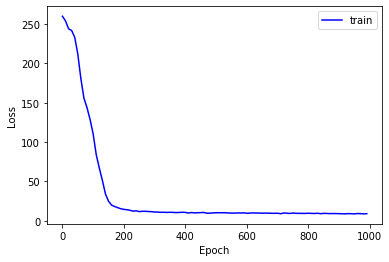

In [23]:
def train(save_model):
  n = 10
  m = 4
  dt = 0.01
  model = DynamicsNN(n, m).cuda()

  lr = 1e-4
  optimizer = torch.optim.Adam(model.parameters(), lr)
  loss_fn = nn.MSELoss()

  epochs = 1000
  batch_size = 500
  data_gen = DataGenerator(n, m, dt, batch_size)

  save_every = 10
  decay_every = 100
  # validate_every = 1000

  epoch_hist = []
  loss_hist = []
  # vals = []

  num_nans = 0

  last_l = 0
  last_e = 0
  info = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    optimizer.zero_grad()

    xu_t, x_tp1 = data_gen.getBatch()
    in_var = Variable(torch.from_numpy(xu_t).float(), requires_grad=True).cuda()
    out_truth = Variable(torch.from_numpy(x_tp1).float(), requires_grad=False).cuda()

    out_pred = model(in_var)

    loss = loss_fn(out_pred, out_truth)

    loss.backward()
    optimizer.step()

    # was getting nans in out_pred and loss because / by 0 in norm calculation 
    # until I removed ReLU from last layer
    loss = loss.item()
    if np.isnan(loss):
      num_nans += 1

    # if epoch % validate_every == 0:
      # validate()

    if epoch % save_every == 0:
      last_l = loss
      last_e = epoch
      epoch_hist.append(epoch)
      loss_hist.append(loss)
      if save_model:
        torch.save(model, 'learned_quadrotor_model.pt')
    
    if epoch % decay_every == 0:
      lr *= 0.9
      for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    info.set_description('Last saved loss: {:.3f}, e: {}'.format(last_l,last_e))
    info.update(1)
  
  fig, ax = plt.subplots()
  train_losses, = ax.plot(epoch_hist, loss_hist, 'b', label='train')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend()
  print('\nNans: ', num_nans)
  print('sample input: ', xu_t[0])
  print('sample output: ', out_pred[0])
  plt.show()

train(save_model=False)

In [15]:
x_test = torch.tensor([[0,0,0,1,0,0,0,0,0,0,0.8,0,0,0]])
model(x_test)

NameError: ignored